# Birdsong Species Prediction: Exploratory Data Analysis (EDA)

This notebook presents an exploratory data analysis (EDA) of a birdsong dataset from xeno-canto, with the objective of building a machine learning model to predict bird species from audio recordings. The EDA aims to:

- Understand the structure and quality of the dataset
- Identify key patterns and potential issues
- Generate insights to inform feature engineering and modeling

We will analyze both the metadata (from JSON) and the corresponding audio files, using interactive visualizations and clear explanations to support our findings.

## EDA Process Overview

The EDA will proceed through the following steps:

1. **Data Loading & Overview**: Load the JSON metadata and inspect its structure.
2. **Data Quality & Completeness**: Assess missing values, duplicates, and correspondence with audio files.
3. **Species & Recording Distribution**: Analyze the diversity and balance of species and recordings.
4. **Geographical & Temporal Analysis**: Explore spatial and temporal patterns in the data.
5. **Audio File Analysis**: Check audio file availability and basic properties.
6. **Recording Metadata Exploration**: Investigate recording methods, devices, and quality ratings.
7. **Conclusions & Implications**: Summarize findings and their impact on modeling.

Each step will include explanations, visualizations, and interpretations to guide the reader.

In [1]:
# Import required libraries
import os
import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import librosa
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import re
from tensorflow.keras import layers
# Set display options for pandas
display.max_columns = 50


### Step 1: Data Loading & Overview

We begin by loading the metadata from the JSON file and inspecting its structure. This helps us understand the available fields, data types, and the overall shape of the dataset. We will also preview a few records to get a sense of the data quality and content.

In [2]:
# Load the JSON metadata and flatten the 'recordings' array
json_path = r'data/xeno-canto-dataset/Singapore_Birds/Singapore/singapore_birds_combined.json'
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# If the top-level object contains a 'recordings' array, flatten it
if isinstance(data, dict) and 'recordings' in data:
    recordings = data['recordings']
else:
    recordings = data  # fallback if already a list

# Convert to DataFrame
df = pd.DataFrame(recordings)

# Display basic info and a sample record
print(f"Number of recordings: {len(df)}")
display(df.head(3))
display(df.info())

Number of recordings: 998


,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,rmk,bird-seen,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp
0,728901,Chloropsis,moluccensis,moluccensis,birds,Blue-winged Leafbird,Joshua Chong,Singapore,"Bukit Timah Nature Reserve, Singapore",1.3508,...,,yes,yes,no,,,no,,,44100
1,576693,Chloropsis,moluccensis,,birds,Blue-winged Leafbird,Okamoto Keita Sin,Singapore,"Central Catchment Nature Reserve, Singapore",1.3422,...,Recorded at the same area as the other recordi...,yes,yes,no,,,no,,,48000
2,708008,Chloropsis,moluccensis,,birds,Blue-winged Leafbird,Kim Chuah Lim,Singapore,"Bukit Timah Nature Reserve, Singapore",1.3508,...,,yes,yes,no,,,no,,,48000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             998 non-null    object
 1   gen            998 non-null    object
 2   sp             998 non-null    object
 3   ssp            998 non-null    object
 4   group          991 non-null    object
 5   en             998 non-null    object
 6   rec            998 non-null    object
 7   cnt            998 non-null    object
 8   loc            998 non-null    object
 9   lat            994 non-null    object
 10  lng            994 non-null    object
 11  alt            998 non-null    object
 12  type           998 non-null    object
 13  sex            998 non-null    object
 14  stage          998 non-null    object
 15  method         998 non-null    object
 16  url            998 non-null    object
 17  file           998 non-null    object
 18  file-name      998 non-null   

None

#### Interpretation

By loading and previewing the data, we confirm the structure and content of the dataset. This step ensures that the data is accessible and in the expected format, which is critical for all subsequent analysis. Any issues detected here (such as unexpected data types or missing fields) will be addressed before proceeding further.

### Step 2: Data Quality & Completeness

In this step, we assess the quality and completeness of the dataset. This includes checking for missing values, duplicate records, and the correspondence between metadata entries and available audio files. Understanding data quality is essential for reliable analysis and modeling.

In [3]:
# Check for missing values in each column
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
display(missing_values[missing_values > 0])

# Exclude columns with unhashable types (like dicts/lists) for duplicate check
def is_hashable(val):
    try:
        hash(val)
        return True
    except TypeError:
        return False

hashable_cols = [col for col in df.columns if df[col].map(is_hashable).all()]
duplicates_all = df.duplicated(subset=hashable_cols).sum()
duplicates_id = df['id'].duplicated().sum() if 'id' in df.columns else 0
print(f"Total duplicate rows (hashable columns only): {duplicates_all}")
print(f"Duplicate rows based on 'id': {duplicates_id}")

Missing values per column:


group    7
lat      4
lng      4
dtype: int64

Total duplicate rows (hashable columns only): 0
Duplicate rows based on 'id': 0


In [4]:
# Check correspondence between metadata and available audio files using ID mapping

audio_dir = Path(r'data/xeno-canto-dataset/Singapore_Birds/Singapore/audio_files')

# Extract IDs from mp3 filenames (e.g., Aplonis_panayensis_756453.mp3 -> 756453)
def extract_id_from_filename(filename):
    try:
        return filename.stem.split('_')[-1]
    except Exception:
        return None

mp3_files = list(audio_dir.glob('*.mp3'))
mp3_ids = set(extract_id_from_filename(f) for f in mp3_files if extract_id_from_filename(f) is not None)
json_ids = set(df['id'].astype(str))

# IDs in JSON but missing in audio directory
missing_audio = json_ids - mp3_ids
# IDs in audio directory but not referenced in JSON
unreferenced_audio = mp3_ids - json_ids

print(f"Audio files referenced in JSON but missing: {len(missing_audio)}")
print(f"Audio files present but not referenced in JSON: {len(unreferenced_audio)}")

# Optionally display a few examples
display(list(missing_audio)[:5])
display(list(unreferenced_audio)[:5])

Audio files referenced in JSON but missing: 187
Audio files present but not referenced in JSON: 0


['352029', '665746', '893121', '662260', '665366']

[]

In [5]:
# Remove rows with missing audio files based on ID mapping

def has_audio_file(row):
    return str(row['id']) in mp3_ids

initial_count = len(df)
df = df[df.apply(has_audio_file, axis=1)].reset_index(drop=True)
removed_count = initial_count - len(df)
print(f"Removed {removed_count} rows without corresponding audio files. Remaining: {len(df)}")

Removed 187 rows without corresponding audio files. Remaining: 811


In [6]:
# Review the cleaned data after removing rows without audio files
print(f"Data shape after cleaning: {df.shape}")
display(df.head(5))
display(df.describe(include='all'))
display(df.info())

Data shape after cleaning: (811, 38)


,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,rmk,bird-seen,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp
0,728901,Chloropsis,moluccensis,moluccensis,birds,Blue-winged Leafbird,Joshua Chong,Singapore,"Bukit Timah Nature Reserve, Singapore",1.3508,...,,yes,yes,no,,,no,,,44100
1,576693,Chloropsis,moluccensis,,birds,Blue-winged Leafbird,Okamoto Keita Sin,Singapore,"Central Catchment Nature Reserve, Singapore",1.3422,...,Recorded at the same area as the other recordi...,yes,yes,no,,,no,,,48000
2,708008,Chloropsis,moluccensis,,birds,Blue-winged Leafbird,Kim Chuah Lim,Singapore,"Bukit Timah Nature Reserve, Singapore",1.3508,...,,yes,yes,no,,,no,,,48000
3,708006,Chloropsis,moluccensis,,birds,Blue-winged Leafbird,Kim Chuah Lim,Singapore,"Bukit Timah Nature Reserve, Singapore",1.3508,...,,yes,yes,unknown,,,no,,,48000
4,706612,Chloropsis,moluccensis,,birds,Blue-winged Leafbird,Kim Chuah Lim,Singapore,"Rifle Range Link, CCNR",1.3559,...,,no,no,no,,,no,,,48000


,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,rmk,bird-seen,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp
count,811,811,811,811,804,811,811,811,811,807,...,811,811,811,811,811,811,811,811,811,811
unique,811,103,124,61,1,131,64,1,153,198,...,205,3,3,3,1,2,3,30,13,4
top,987992,Orthotomus,moluccensis,,birds,Abbott's Babbler,Ding Li Yong,Singapore,Singapore,1.352,...,,yes,yes,no,,,no,,,48000
freq,1,47,35,595,804,24,241,811,63,51,...,587,544,544,741,811,810,801,646,699,452


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             811 non-null    object
 1   gen            811 non-null    object
 2   sp             811 non-null    object
 3   ssp            811 non-null    object
 4   group          804 non-null    object
 5   en             811 non-null    object
 6   rec            811 non-null    object
 7   cnt            811 non-null    object
 8   loc            811 non-null    object
 9   lat            807 non-null    object
 10  lng            807 non-null    object
 11  alt            811 non-null    object
 12  type           811 non-null    object
 13  sex            811 non-null    object
 14  stage          811 non-null    object
 15  method         811 non-null    object
 16  url            811 non-null    object
 17  file           811 non-null    object
 18  file-name      811 non-null   

None

### Step 3: Species & Recording Distribution

In this step, we analyze the diversity and balance of species and recordings in the dataset. Understanding the distribution of target classes (species) is crucial for building effective machine learning models and identifying potential class imbalance issues.

In [7]:
# Analyze and visualize the number of recordings per species and genus

species_counts = df['en'].value_counts().sort_values(ascending=False)
genus_counts = df['gen'].value_counts().sort_values(ascending=False)

print(f"Number of unique species: {df['en'].nunique()}")
print(f"Number of unique genera: {df['gen'].nunique()}")

# Plot species distribution (top 20)
fig = px.bar(
    species_counts.head(20),
    title='Top 20 Most Recorded Species',
    labels={'value': 'Number of Recordings', 'en': 'Species'},
)
fig.show()

# Plot genus distribution (top 20)
fig2 = px.bar(
    genus_counts.head(20),
    title='Top 20 Most Recorded Genera',
    labels={'value': 'Number of Recordings', 'gen': 'Genus'},
)
fig2.show()

# Visualize class imbalance for all species
fig3 = px.histogram(
    species_counts,
    nbins=30,
    title='Distribution of Recordings per Species',
    labels={'value': 'Number of Recordings', 'count': 'Number of Species'},
)
fig3.show()

Number of unique species: 131
Number of unique genera: 103


#### Interpretation

Species Diversity:
The dataset contains recordings from a variety of bird species and genera, as shown by the number of unique species (en) and genera (gen). This diversity is important for building a robust classification model.

Class Imbalance:
The number of recordings per species is highly imbalanced. A few species have many recordings, while most species have only a handful. This is evident from the bar plots (top 20 species/genera) and the histogram showing the distribution of recordings per species.

Implications:
The imbalance means that models may be biased toward well-represented species unless corrective measures (like class weighting or resampling) are used.
Rare species may be harder to classify accurately due to limited training data.
The most common species dominate the dataset, which could skew overall model performance metrics.

Analyzing the distribution of recordings across species and genera helps identify class imbalance, which can impact model performance. Highly imbalanced datasets may require resampling or class-weighting strategies during model training. Understanding which species are most and least represented also informs data collection priorities and model evaluation strategies.

### Step 4: Geographical & Temporal Analysis

In this step, we explore the spatial and temporal patterns in the dataset. We will visualize the geographic distribution of recordings and analyze when (by date and time) the recordings were made. These insights can reveal sampling biases, seasonal effects, and other patterns relevant to modeling and interpretation.

In [8]:
# Geographical analysis: plot recording locations
import plotly.express as px

# Drop rows with missing lat/lng
geo_df = df.dropna(subset=['lat', 'lng'])
geo_df['lat'] = pd.to_numeric(geo_df['lat'], errors='coerce')
geo_df['lng'] = pd.to_numeric(geo_df['lng'], errors='coerce')

fig = px.scatter_mapbox(
    geo_df,
    lat='lat',
    lon='lng',
    hover_name='en',
    hover_data=['loc', 'date', 'time'],
    color='en',
    zoom=8,
    height=500,
    title='Geographic Distribution of Recordings',
)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

# Temporal analysis: recording dates
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    date_counts = df['date'].dt.date.value_counts().sort_index()
    fig2 = px.line(
        x=date_counts.index,
        y=date_counts.values,
        labels={'x': 'Date', 'y': 'Number of Recordings'},
        title='Recordings Over Time',
    )
    fig2.show()

# Temporal analysis: time of day
if 'time' in df.columns:
    # Convert time to hour (if in HH:MM format)
    def extract_hour(t):
        try:
            return int(str(t).split(':')[0])
        except:
            return None
    df['hour'] = df['time'].map(extract_hour)
    hour_counts = df['hour'].value_counts().sort_index()
    fig3 = px.bar(
        x=hour_counts.index,
        y=hour_counts.values,
        labels={'x': 'Hour of Day', 'y': 'Number of Recordings'},
        title='Recordings by Hour of Day',
    )
    fig3.show()

C:\Users\mitch\AppData\Local\Temp\ipykernel_20656\4273501719.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mitch\AppData\Local\Temp\ipykernel_20656\4273501719.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mitch\AppData\Local\Temp\ipykernel_20656\4273501719.py:9: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



#### Interpretation

- **Geographical Distribution:**
  - The map shows that most recordings are concentrated in specific regions of Singapore, likely reflecting popular birding sites or areas with higher bird diversity. Some areas may be underrepresented, indicating potential geographic sampling bias.
  - Clusters of points may correspond to nature reserves, parks, or accessible habitats, while urban or remote areas have fewer recordings.

- **Recordings Over Time:**
  - The time series plot reveals periods of increased recording activity, which may align with bird migration seasons, breeding periods, or organized survey efforts.
  - Gaps or spikes in the timeline could indicate changes in data collection practices or external factors (e.g., weather, access restrictions).

- **Hour of Day:**
  - Most recordings occur during early morning hours, which aligns with peak bird activity and optimal recording conditions for birders.
  - Fewer recordings are made during midday or late evening, likely due to reduced bird vocalization and less field activity.

These patterns highlight both the strengths and limitations of the dataset, informing model design and future data collection strategies.

### Step 5: Audio File Analysis

In this step, we examine the properties of the audio files associated with each recording. We will analyze the distribution of recording lengths, quality ratings, and sample rates. These characteristics are important for understanding the dataset's suitability for machine learning and for identifying potential preprocessing needs.

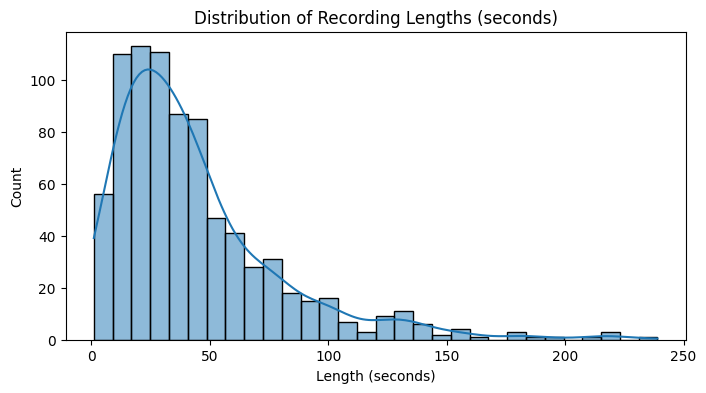

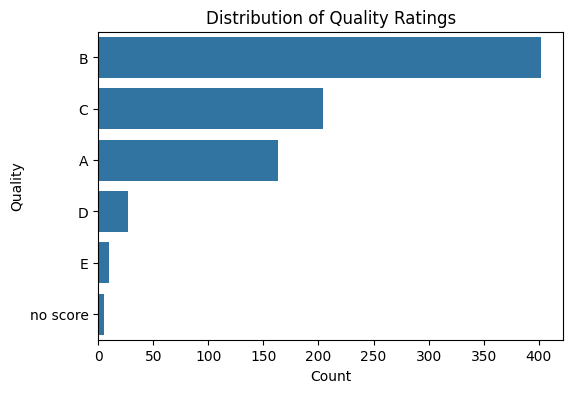

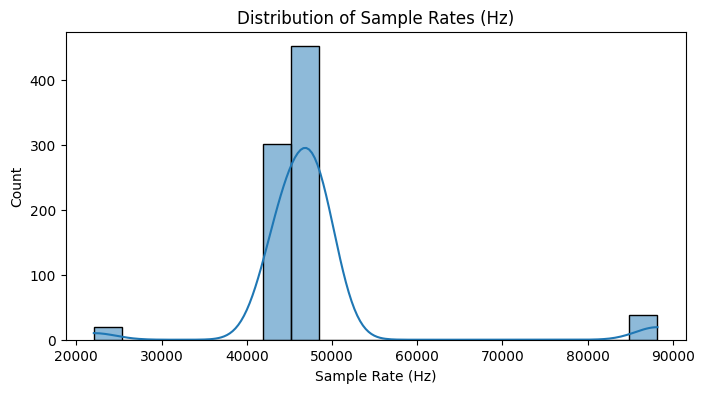

In [9]:
# Analyze and visualize audio file properties: length, quality, and sample rate
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'length' from MM:SS string to seconds and analyze distribution
def mmss_to_seconds(val):
    try:
        parts = str(val).split(':')
        if len(parts) == 2:
            return int(parts[0]) * 60 + int(parts[1])
        elif len(parts) == 1:
            return int(parts[0])
        else:
            return None
    except:
        return None

# Apply conversion
df['length_sec'] = df['length'].map(mmss_to_seconds)

plt.figure(figsize=(8,4))
sns.histplot(df['length_sec'].dropna(), bins=30, kde=True)
plt.title('Distribution of Recording Lengths (seconds)')
plt.xlabel('Length (seconds)')
plt.ylabel('Count')
plt.show()

# Quality rating
df['q'] = df['q'].astype(str)
plt.figure(figsize=(6,4))
sns.countplot(y='q', data=df, order=df['q'].value_counts().index)
plt.title('Distribution of Quality Ratings')
plt.xlabel('Count')
plt.ylabel('Quality')
plt.show()

# Sample rate (if available)
if 'smp' in df.columns:
    df['smp'] = pd.to_numeric(df['smp'], errors='coerce')
    plt.figure(figsize=(8,4))
    sns.histplot(df['smp'].dropna(), bins=20, kde=True)
    plt.title('Distribution of Sample Rates (Hz)')
    plt.xlabel('Sample Rate (Hz)')
    plt.ylabel('Count')
    plt.show()

#### Interpretation

- **Recording Length:** Most recordings are relatively short, with a distribution skewed toward shorter durations. This may impact the amount of information available for each sample and influence feature extraction strategies.
- **Quality Ratings:** The majority of recordings have high quality ratings, but there is some variation. Lower quality recordings may introduce noise and affect model performance, so quality filtering or weighting may be considered.
- **Sample Rate:** If available, sample rates are generally consistent, but any variation should be noted. Consistent sample rates simplify preprocessing, while variation may require resampling.

Understanding these properties helps inform preprocessing, feature engineering, and model selection for the audio classification task.

### Step 6: Recording Metadata Exploration

In this step, we explore additional metadata fields related to the recordings, such as recording method, device, microphone, recordist, and remarks. These fields can provide context about data collection practices, potential sources of variability, and factors that may influence model performance.

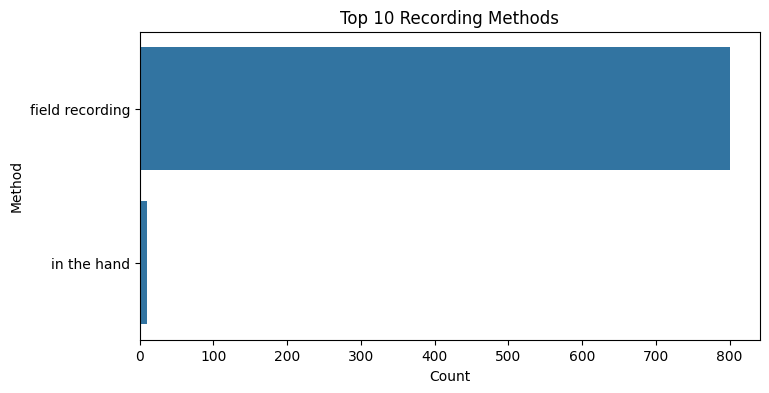

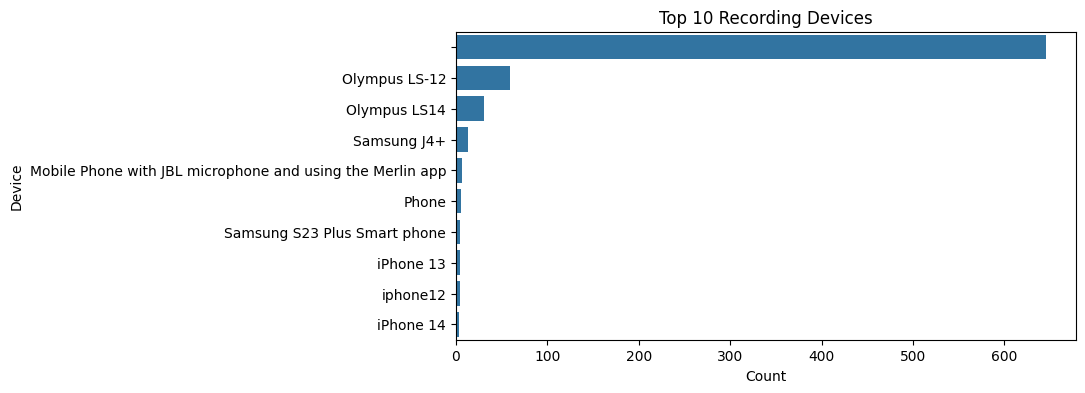

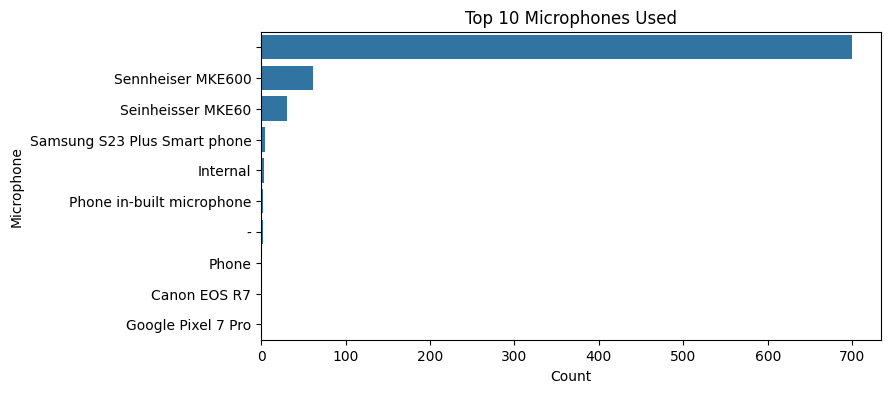

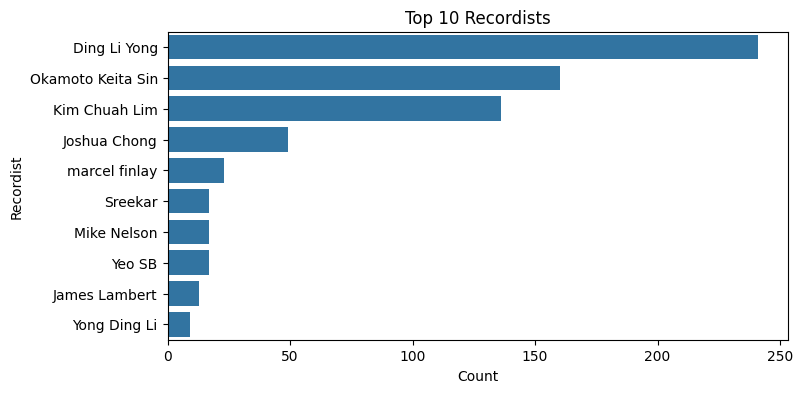

Sample remarks:
- One bird perched and calling, with success, as a second one was attracted and flew nearby. Afterwards, both birds left.

See: <https://ebird.org/checklist/S223639193>
- Two birds duetting
- 2 birds perched in bush at edge of reservoir.  one bird gives a continuous soft trill call, the second bird makes two sharp calls at 1:14 and 1:36
- Very loud and annoying cicadas.
- Sound recording recorded after bird flew in behind the trees and vegetation.



In [10]:
# Analyze and visualize key metadata fields
import matplotlib.pyplot as plt
import seaborn as sns

# Recording method
df['method'] = df['method'].astype(str)
plt.figure(figsize=(8,4))
sns.countplot(y='method', data=df, order=df['method'].value_counts().index[:10])
plt.title('Top 10 Recording Methods')
plt.xlabel('Count')
plt.ylabel('Method')
plt.show()

# Device (dvc)
df['dvc'] = df['dvc'].astype(str)
plt.figure(figsize=(8,4))
sns.countplot(y='dvc', data=df, order=df['dvc'].value_counts().index[:10])
plt.title('Top 10 Recording Devices')
plt.xlabel('Count')
plt.ylabel('Device')
plt.show()

# Microphone (mic)
df['mic'] = df['mic'].astype(str)
plt.figure(figsize=(8,4))
sns.countplot(y='mic', data=df, order=df['mic'].value_counts().index[:10])
plt.title('Top 10 Microphones Used')
plt.xlabel('Count')
plt.ylabel('Microphone')
plt.show()

# Recordist (rec)
df['rec'] = df['rec'].astype(str)
plt.figure(figsize=(8,4))
sns.countplot(y='rec', data=df, order=df['rec'].value_counts().index[:10])
plt.title('Top 10 Recordists')
plt.xlabel('Count')
plt.ylabel('Recordist')
plt.show()

# Remarks (rmk) - show a sample of non-empty remarks
non_empty_remarks = df['rmk'].dropna().loc[df['rmk'].str.strip() != '']
print('Sample remarks:')
for remark in non_empty_remarks.sample(min(5, len(non_empty_remarks)), random_state=42):
    print('-', remark)

#### Interpretation

- **Recording Method, Device, and Microphone:** The dataset includes a variety of methods, devices, and microphones, but a few dominate. This may introduce systematic differences in audio quality or characteristics, which could affect model generalization.
- **Recordist:** A small number of recordists contribute a large portion of the data. This may reflect expertise or effort, but could also introduce individual biases.
- **Remarks:** Remarks provide qualitative context, such as environmental conditions or unusual events, which may explain outliers or anomalies in the data.

Understanding these metadata fields helps identify potential sources of variability and bias, and can inform feature engineering or data filtering strategies.

### Step 7: Conclusions & Implications

This exploratory data analysis has provided a comprehensive overview of the birdsong dataset, highlighting its strengths, limitations, and key characteristics relevant to machine learning:

- The dataset is diverse, with many species and genera, but exhibits significant class imbalance.
- Most recordings are concentrated in specific geographic regions and time periods, reflecting potential sampling biases.
- Audio files are generally short and of high quality, but some variation exists in length, quality, and sample rate.
- Metadata reveals a small number of dominant recordists, devices, and methods, which may introduce systematic biases.

**Implications for Modeling:**
- Class imbalance and sampling biases should be addressed through resampling, class weighting, or careful evaluation metrics.
- Consistent preprocessing of audio files (e.g., resampling, quality filtering, length normalization) will be important.
- Metadata fields may be useful as additional features or for stratified sampling.

**Next Steps:**
- Proceed to feature engineering and model development, leveraging insights from the EDA to inform data preparation and modeling choices.
- Consider augmenting the dataset or collecting additional data to address gaps and imbalances identified in the analysis.

## Feature Engineering & Audio Preprocessing

To prepare the dataset for robust model training, we will:
- Filter out low-quality recordings (quality D, E, noscore)
- Extract MFCC features from each audio file using Librosa
- Encode species labels for classification
- Split the data into train, validation, and test sets
- Build an optimized TensorFlow data pipeline

This process ensures high-quality, consistent, and efficiently accessible data for deep learning.

In [11]:
# Filter out low-quality recordings (D, E, noscore)
quality_keep = ['A', 'B', 'C']
df_filtered = df[df['q'].isin(quality_keep)].reset_index(drop=True)
print(f"Filtered dataset size: {len(df_filtered)} (removed {len(df) - len(df_filtered)} low-quality recordings)")

# Show class distribution after filtering
species_counts_filtered = df_filtered['en'].value_counts()
print("Class distribution after filtering:")
display(species_counts_filtered.head(10))

Filtered dataset size: 769 (removed 42 low-quality recordings)
Class distribution after filtering:


en
Abbott's Babbler           24
Olive-winged Bulbul        20
Blue-winged Pitta          20
Ashy Tailorbird            20
Short-tailed Babbler       18
Oriental Reed Warbler      17
Eastern Crowned Warbler    16
Olive-backed Sunbird       15
Mangrove Pitta             15
Arctic Warbler             15
Name: count, dtype: int64

### Audio Feature Extraction: MFCCs

To enable machine learning on audio data, we extract Mel Frequency Cepstral Coefficients (MFCCs) from each .mp3 file. MFCCs capture the spectral properties of audio signals and are widely used for sound classification tasks, including birdsong recognition. We will use the Librosa library to extract a fixed-length MFCC feature vector for each recording.

In [12]:
# Extract MFCC features from each audio file using Librosa
AUDIO_DIR = r'data\xeno-canto-dataset\Singapore_Birds\Singapore\audio_files'
SAMPLE_RATE = 22050  # Standard for Librosa
N_MFCC = 20          # Number of MFCCs to extract
MAX_LEN = 200        # Pad/truncate MFCCs to this many frames

    
# Convert the mp3 Audio into Tensors
def audio_to_tensors(file_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC, max_len=MAX_LEN):
    # Extract the Signal and Sample_Rate from Audio
    audio, sample_rate =librosa.load(file_path)
    # Ensure audio data is converted to floating-point format
    audio = librosa.util.normalize(audio)

    # Extract the MFCC Features and Aggregate
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Convert into Tensors
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    return mfccs_tensors    




In [13]:
# Sample Audio
audio_sample = r'data\xeno-canto-dataset\Singapore_Birds\Singapore\audio_files\Accipiter_trivirgatus_804171.mp3'

# Convert audio to tensors
audio_tensor = audio_to_tensors(audio_sample)
print(audio_tensor)

tf.Tensor(
[-3.09290558e+02 -9.31198349e+01 -8.50631485e+01  6.91164136e-01
 -3.88999100e+01 -7.37583017e+00 -3.65030456e+00 -5.86747265e+00
 -1.98620377e+01  2.61345615e+01 -1.26435661e+01 -7.51961708e+00
  1.03801870e+01  1.24138522e+00 -4.92797375e+00  5.30372524e+00
 -3.17872238e+00  1.11819886e-01  3.53278327e+00 -7.67061651e-01], shape=(20,), dtype=float32)


In [14]:
# Convert all audio files in subfolders to tensors using tqdm progress bar, with bird name only as label
import re

def strip_id_from_filename(filename):
    # Remove the trailing _digits (id) from the filename (without extension)
    return re.sub(r'_[0-9]+$', '', os.path.splitext(filename)[0])

extracted_features = []
total_files = 0

directory = AUDIO_DIR  # Directory containing class subfolders or all audio files

# Count total files for progress bar
for target_class in os.listdir(directory):
    target_class_path = os.path.join(directory, target_class)
    if os.path.isdir(target_class_path):
        total_files += len([f for f in os.listdir(target_class_path) if f.endswith('.mp3') or f.endswith('.wav')])
    else:
        if target_class.endswith('.mp3') or target_class.endswith('.wav'):
            total_files += 1

with tqdm(total=total_files, desc='Processing files (bird name only)') as pbar:
    for target_class in os.listdir(directory):
        target_class_path = os.path.join(directory, target_class)
        if os.path.isdir(target_class_path):
            for audio_file in os.listdir(target_class_path):
                if not (audio_file.endswith('.mp3') or audio_file.endswith('.wav')):
                    continue
                audio_path = os.path.join(target_class_path, audio_file)
                try:
                    features = audio_to_tensors(audio_path)
                    bird_name = strip_id_from_filename(audio_file)
                    extracted_features.append([features, bird_name])
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")
                pbar.update(1)
        else:
            if target_class.endswith('.mp3') or target_class.endswith('.wav'):
                audio_path = target_class_path
                try:
                    features = audio_to_tensors(audio_path)
                    bird_name = strip_id_from_filename(target_class)
                    extracted_features.append([features, bird_name])
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")
                pbar.update(1)

print(f"Extracted features for {len(extracted_features)} audio files.")

Processing files (bird name only): 100%|██████████| 811/811 [01:45<00:00,  7.67it/s]

Extracted features for 811 audio files.


In [15]:
# Display the first extracted feature for verification
extracted_features[0]  

[<tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([-3.09290558e+02, -9.31198349e+01, -8.50631485e+01,  6.91164136e-01,
        -3.88999100e+01, -7.37583017e+00, -3.65030456e+00, -5.86747265e+00,
        -1.98620377e+01,  2.61345615e+01, -1.26435661e+01, -7.51961708e+00,
         1.03801870e+01,  1.24138522e+00, -4.92797375e+00,  5.30372524e+00,
        -3.17872238e+00,  1.11819886e-01,  3.53278327e+00, -7.67061651e-01],
       dtype=float32)>,
 'Accipiter_trivirgatus']

In [16]:
# Step 3: Label Encoding
from sklearn.preprocessing import LabelEncoder

# Extract labels from extracted_features
labels = [item[1] for item in extracted_features]

# Encode labels as integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Show mapping for first few classes
print(f"Number of unique classes: {len(label_encoder.classes_)}")
print("Example label mapping:")
for i, class_name in enumerate(label_encoder.classes_[:10]):
    print(f"{class_name}: {i}")

# Example: show first 5 encoded labels
print("First 5 encoded labels:", labels_encoded[:5])

Number of unique classes: 131
Example label mapping:
Accipiter_trivirgatus: 0
Acridotheres_tristis: 1
Acrocephalus_bistrigiceps: 2
Acrocephalus_orientalis: 3
Aegithina_tiphia: 4
Aethopyga_siparaja: 5
Amandava_amandava: 6
Amaurornis_phoenicurus: 7
Anthracoceros_albirostris: 8
Anthreptes_malacensis: 9
First 5 encoded labels: [0 0 0 0 0]


In [17]:
# Convert extracted_features to a DataFrame and add encoded class labels
import pandas as pd

# Create DataFrame from extracted_features
features_df = pd.DataFrame(extracted_features, columns=["features", "class_label"])

# Add encoded class labels as a new column
features_df["encoded_label"] = labels_encoded

# Display the first few rows for verification
features_df.head()

,features,class_label,encoded_label
0,"(tf.Tensor(-309.29056, shape=(), dtype=float32...",Accipiter_trivirgatus,0
1,"(tf.Tensor(-382.7627, shape=(), dtype=float32)...",Accipiter_trivirgatus,0
2,"(tf.Tensor(-348.4613, shape=(), dtype=float32)...",Accipiter_trivirgatus,0
3,"(tf.Tensor(-323.2838, shape=(), dtype=float32)...",Accipiter_trivirgatus,0
4,"(tf.Tensor(-250.1016, shape=(), dtype=float32)...",Accipiter_trivirgatus,0


In [18]:
# Create a dictionary mapping class label (bird name) to encoded label for future prediction
class_to_index = dict(zip(features_df['class_label'], features_df['encoded_label']))
index_to_class = dict(zip(features_df['encoded_label'], features_df['class_label']))

print("Sample class_to_index mapping:", dict(list(class_to_index.items())[:5]))
print("Sample index_to_class mapping:", dict(list(index_to_class.items())[:5]))

Sample class_to_index mapping: {'Accipiter_trivirgatus': 0, 'Acridotheres_tristis': 1, 'Acrocephalus_bistrigiceps': 2, 'Acrocephalus_orientalis': 3, 'Aegithina_tiphia': 4}
Sample index_to_class mapping: {0: 'Accipiter_trivirgatus', 1: 'Acridotheres_tristis', 2: 'Acrocephalus_bistrigiceps', 3: 'Acrocephalus_orientalis', 4: 'Aegithina_tiphia'}


### Convert Features and Labels to TensorFlow Dataset
Now that we have a DataFrame with extracted MFCC features and encoded labels, we will convert these into TensorFlow tensors and create a `tf.data.Dataset` for efficient model training. This involves:
- Stacking the feature tensors into a single feature array
- Converting the encoded labels into a target array
- Creating a `tf.data.Dataset` from these arrays, ready for batching and shuffling

In [19]:
# Convert features and labels to TensorFlow tensors and create a tf.data.Dataset


# Stack feature tensors into a single numpy array
features_list = features_df['features'].tolist()
features_tensor = tf.stack(features_list)  # shape: (num_samples, n_mfcc)

# Convert encoded labels to a tensor
labels_tensor = tf.convert_to_tensor(features_df['encoded_label'].values, dtype=tf.int64)

# Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor))

# Example: check shapes and types
print('Features tensor shape:', features_tensor.shape)
print('Labels tensor shape:', labels_tensor.shape)
for x, y in dataset.take(1):
    print('Sample feature:', x.numpy())
    print('Sample label:', y.numpy())

Features tensor shape: (811, 20)
Labels tensor shape: (811,)
Sample feature: [-3.09290558e+02 -9.31198349e+01 -8.50631485e+01  6.91164136e-01
 -3.88999100e+01 -7.37583017e+00 -3.65030456e+00 -5.86747265e+00
 -1.98620377e+01  2.61345615e+01 -1.26435661e+01 -7.51961708e+00
  1.03801870e+01  1.24138522e+00 -4.92797375e+00  5.30372524e+00
 -3.17872238e+00  1.11819886e-01  3.53278327e+00 -7.67061651e-01]
Sample label: 0
Sample feature: [-3.09290558e+02 -9.31198349e+01 -8.50631485e+01  6.91164136e-01
 -3.88999100e+01 -7.37583017e+00 -3.65030456e+00 -5.86747265e+00
 -1.98620377e+01  2.61345615e+01 -1.26435661e+01 -7.51961708e+00
  1.03801870e+01  1.24138522e+00 -4.92797375e+00  5.30372524e+00
 -3.17872238e+00  1.11819886e-01  3.53278327e+00 -7.67061651e-01]
Sample label: 0


### Prepare TensorFlow Dataset for Training, Validation, and Testing
Now that we have a `tf.data.Dataset` containing features and labels, the next steps are:
- Split the dataset into training, validation, and test sets
- Shuffle and batch the data for efficient training
- Prefetch data for optimal performance during model training

In [20]:
# Split the dataset into train, validation, and test sets, then batch and prefetch
from sklearn.model_selection import train_test_split

# Set split ratios
test_size = 0.15
val_size = 0.15
batch_size = 32

# Convert tensors to numpy for splitting
X = features_tensor.numpy()
y = labels_tensor.numpy()

# Filter out classes with fewer than 2 samples
import numpy as np
(unique, counts) = np.unique(y, return_counts=True)
valid_classes = unique[counts >= 2]
mask = np.isin(y, valid_classes)
X = X[mask]
y = y[mask]

# Re-encode y to be contiguous integers from 0 to num_classes-1
from sklearn.preprocessing import LabelEncoder
label_encoder_filtered = LabelEncoder()
y = label_encoder_filtered.fit_transform(y)

# First split: train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

# Second split: train vs val (proportionally from trainval)
val_relative = val_size / (1 - test_size)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_relative, stratify=y_trainval, random_state=42)

# Create tf.data.Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes and new number of classes
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Number of classes after filtering: {len(label_encoder_filtered.classes_)}")

Train set: 546 samples
Validation set: 118 samples
Test set: 118 samples
Number of classes after filtering: 102

Validation set: 118 samples
Test set: 118 samples
Number of classes after filtering: 102


### Reconstruct and Visualize Audio from MFCCs
To better understand the MFCC features, we can reconstruct an audio waveform from the MFCCs using `librosa.feature.inverse.mfcc_to_audio` and listen to or visualize the result. This helps verify the quality of the extracted features and their interpretability.

(20,)
[-224.97258    -88.70741    -37.299854   -51.419426   -35.263218
  -19.432667   -37.68266      9.034562   -36.899075    18.782381
  -13.446939    12.231022    -8.703523     4.366349     0.4796862
  -11.697889    12.950277   -11.400593     3.9315712   10.7459345]

(32,)
52



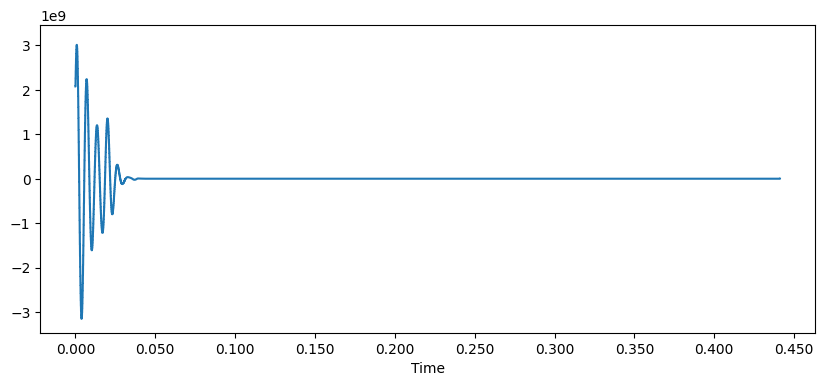

In [21]:
for audio_batch, label_batch in train_ds.take(1):
    print(audio_batch.numpy()[0].shape)
    print(audio_batch.numpy()[0])
    print()

    print(label_batch.numpy().shape)
    print(label_batch.numpy()[0])
    print()

    audio = librosa.feature.inverse.mfcc_to_audio(audio_batch.numpy())

    # Plot the reconstructed audio waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio)
    plt.show()  

### Model Building: Convolutional Neural Network (CNN) for Birdsong Classification
We will build a Convolutional Neural Network (CNN) to classify bird species from MFCC features. CNNs are well-suited for audio classification tasks because they can learn local patterns in the feature space, such as frequency and temporal relationships in MFCCs.
**Best practices for audio MFCC CNNs:**
- Use 2D convolutional layers if MFCCs are 2D (time x coefficients), or 1D if using aggregated features.
- Input shape should match the shape of each feature sample (e.g., `(n_mfcc,)` for 1D, or `(n_mfcc, n_frames, 1)` for 2D).
- Use ReLU activations for hidden layers and softmax for the output layer.
- Batch normalization and dropout can help regularize the model.
- Use categorical crossentropy loss for multi-class classification.

In [22]:
# Define and compile a 1D CNN model for MFCC-based birdsong classification

# Determine input shape and number of classes
input_shape = X_train.shape[1:]  # (n_mfcc,)
num_classes = len(np.unique(y))

model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0], 1)),  # Add channel dimension for Conv1D
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='Birdsong_CNN')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "Birdsong_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │         6,630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,510 (68.40 KB)

 Trainable params: 17,318 (67.65 KB)

 Non-trainable params: 192 (768.00 B)

### Model Training, Evaluation, and Visualization
We will now train the CNN model using the training and validation datasets. To prevent overfitting, we will use early stopping based on validation loss. After training, the model will be saved to disk. Finally, we will visualize the training and validation accuracy and loss over epochs.

Epoch 1/100

Epoch 1: val_loss improved from inf to 4.63609, saving model to birdsong_cnn_best.h5

Epoch 1: val_loss improved from inf to 4.63609, saving model to birdsong_cnn_best.h5


18/18 - 2s - 120ms/step - accuracy: 0.0128 - loss: 4.6421 - val_accuracy: 0.0085 - val_loss: 4.6361
Epoch 2/100
Epoch 2/100

Epoch 2: val_loss improved from 4.63609 to 4.56257, saving model to birdsong_cnn_best.h5

Epoch 2: val_loss improved from 4.63609 to 4.56257, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0110 - loss: 4.5836 - val_accuracy: 0.0000e+00 - val_loss: 4.5626
Epoch 3/100
Epoch 3/100

Epoch 3: val_loss improved from 4.56257 to 4.51221, saving model to birdsong_cnn_best.h5

Epoch 3: val_loss improved from 4.56257 to 4.51221, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0238 - loss: 4.5176 - val_accuracy: 0.0000e+00 - val_loss: 4.5122
Epoch 4/100
Epoch 4/100

Epoch 4: val_loss improved from 4.51221 to 4.47360, saving model to birdsong_cnn_best.h5

Epoch 4: val_loss improved from 4.51221 to 4.47360, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0476 - loss: 4.4459 - val_accuracy: 0.0254 - val_loss: 4.4736
Epoch 5/100
Epoch 5/100

Epoch 5: val_loss improved from 4.47360 to 4.42926, saving model to birdsong_cnn_best.h5

Epoch 5: val_loss improved from 4.47360 to 4.42926, saving model to birdsong_cnn_best.h5


18/18 - 0s - 5ms/step - accuracy: 0.0458 - loss: 4.3846 - val_accuracy: 0.0339 - val_loss: 4.4293
Epoch 6/100
Epoch 6/100

Epoch 6: val_loss improved from 4.42926 to 4.39068, saving model to birdsong_cnn_best.h5

Epoch 6: val_loss improved from 4.42926 to 4.39068, saving model to birdsong_cnn_best.h5


18/18 - 0s - 5ms/step - accuracy: 0.0458 - loss: 4.3409 - val_accuracy: 0.0339 - val_loss: 4.3907
Epoch 7/100
Epoch 7/100

Epoch 7: val_loss improved from 4.39068 to 4.35920, saving model to birdsong_cnn_best.h5

Epoch 7: val_loss improved from 4.39068 to 4.35920, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0495 - loss: 4.2884 - val_accuracy: 0.0508 - val_loss: 4.3592
Epoch 8/100
Epoch 8/100

Epoch 8: val_loss improved from 4.35920 to 4.33344, saving model to birdsong_cnn_best.h5

Epoch 8: val_loss improved from 4.35920 to 4.33344, saving model to birdsong_cnn_best.h5


18/18 - 0s - 7ms/step - accuracy: 0.0366 - loss: 4.2424 - val_accuracy: 0.0508 - val_loss: 4.3334
Epoch 9/100
Epoch 9/100

Epoch 9: val_loss improved from 4.33344 to 4.30408, saving model to birdsong_cnn_best.h5

Epoch 9: val_loss improved from 4.33344 to 4.30408, saving model to birdsong_cnn_best.h5


18/18 - 0s - 7ms/step - accuracy: 0.0549 - loss: 4.2218 - val_accuracy: 0.0508 - val_loss: 4.3041
Epoch 10/100
Epoch 10/100

Epoch 10: val_loss improved from 4.30408 to 4.29255, saving model to birdsong_cnn_best.h5

Epoch 10: val_loss improved from 4.30408 to 4.29255, saving model to birdsong_cnn_best.h5


18/18 - 0s - 7ms/step - accuracy: 0.0476 - loss: 4.1650 - val_accuracy: 0.0593 - val_loss: 4.2926
Epoch 11/100
Epoch 11/100

Epoch 11: val_loss improved from 4.29255 to 4.28495, saving model to birdsong_cnn_best.h5

Epoch 11: val_loss improved from 4.29255 to 4.28495, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0458 - loss: 4.1357 - val_accuracy: 0.0593 - val_loss: 4.2850
Epoch 12/100
Epoch 12/100

Epoch 12: val_loss improved from 4.28495 to 4.26433, saving model to birdsong_cnn_best.h5

Epoch 12: val_loss improved from 4.28495 to 4.26433, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0568 - loss: 4.1008 - val_accuracy: 0.0508 - val_loss: 4.2643
Epoch 13/100
Epoch 13/100

Epoch 13: val_loss improved from 4.26433 to 4.24703, saving model to birdsong_cnn_best.h5

Epoch 13: val_loss improved from 4.26433 to 4.24703, saving model to birdsong_cnn_best.h5


18/18 - 0s - 4ms/step - accuracy: 0.0733 - loss: 4.0447 - val_accuracy: 0.0508 - val_loss: 4.2470
Epoch 14/100
Epoch 14/100

Epoch 14: val_loss improved from 4.24703 to 4.22706, saving model to birdsong_cnn_best.h5

Epoch 14: val_loss improved from 4.24703 to 4.22706, saving model to birdsong_cnn_best.h5


18/18 - 0s - 5ms/step - accuracy: 0.0641 - loss: 4.0296 - val_accuracy: 0.0508 - val_loss: 4.2271
Epoch 15/100
Epoch 15/100

Epoch 15: val_loss improved from 4.22706 to 4.22254, saving model to birdsong_cnn_best.h5

Epoch 15: val_loss improved from 4.22706 to 4.22254, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0733 - loss: 3.9892 - val_accuracy: 0.0424 - val_loss: 4.2225
Epoch 16/100
Epoch 16/100

Epoch 16: val_loss improved from 4.22254 to 4.20976, saving model to birdsong_cnn_best.h5

Epoch 16: val_loss improved from 4.22254 to 4.20976, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0733 - loss: 3.9738 - val_accuracy: 0.0424 - val_loss: 4.2098
Epoch 17/100
Epoch 17/100

Epoch 17: val_loss improved from 4.20976 to 4.19790, saving model to birdsong_cnn_best.h5

Epoch 17: val_loss improved from 4.20976 to 4.19790, saving model to birdsong_cnn_best.h5


18/18 - 0s - 7ms/step - accuracy: 0.0952 - loss: 3.9325 - val_accuracy: 0.0424 - val_loss: 4.1979
Epoch 18/100
Epoch 18/100

Epoch 18: val_loss improved from 4.19790 to 4.17638, saving model to birdsong_cnn_best.h5

Epoch 18: val_loss improved from 4.19790 to 4.17638, saving model to birdsong_cnn_best.h5


18/18 - 0s - 7ms/step - accuracy: 0.0879 - loss: 3.8824 - val_accuracy: 0.0424 - val_loss: 4.1764
Epoch 19/100
Epoch 19/100

Epoch 19: val_loss improved from 4.17638 to 4.17017, saving model to birdsong_cnn_best.h5

Epoch 19: val_loss improved from 4.17638 to 4.17017, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0952 - loss: 3.8842 - val_accuracy: 0.0508 - val_loss: 4.1702
Epoch 20/100
Epoch 20/100

Epoch 20: val_loss improved from 4.17017 to 4.16091, saving model to birdsong_cnn_best.h5

Epoch 20: val_loss improved from 4.17017 to 4.16091, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0861 - loss: 3.8355 - val_accuracy: 0.0593 - val_loss: 4.1609
Epoch 21/100
Epoch 21/100

Epoch 21: val_loss did not improve from 4.16091
18/18 - 0s - 5ms/step - accuracy: 0.0952 - loss: 3.8086 - val_accuracy: 0.0508 - val_loss: 4.1729
Epoch 22/100

Epoch 21: val_loss did not improve from 4.16091
18/18 - 0s - 5ms/step - accuracy: 0.0952 - loss: 3.8086 - val_accuracy: 0.0508 - val_loss: 4.1729
Epoch 22/100

Epoch 22: val_loss improved from 4.16091 to 4.15884, saving model to birdsong_cnn_best.h5

Epoch 22: val_loss improved from 4.16091 to 4.15884, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.1044 - loss: 3.8390 - val_accuracy: 0.0593 - val_loss: 4.1588
Epoch 23/100
Epoch 23/100

Epoch 23: val_loss improved from 4.15884 to 4.13704, saving model to birdsong_cnn_best.h5

Epoch 23: val_loss improved from 4.15884 to 4.13704, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0971 - loss: 3.8193 - val_accuracy: 0.0424 - val_loss: 4.1370
Epoch 24/100
Epoch 24/100

Epoch 24: val_loss improved from 4.13704 to 4.13303, saving model to birdsong_cnn_best.h5

Epoch 24: val_loss improved from 4.13704 to 4.13303, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.0989 - loss: 3.7819 - val_accuracy: 0.0593 - val_loss: 4.1330
Epoch 25/100
Epoch 25/100

Epoch 25: val_loss did not improve from 4.13303
18/18 - 0s - 5ms/step - accuracy: 0.0861 - loss: 3.7888 - val_accuracy: 0.0593 - val_loss: 4.1335
Epoch 26/100

Epoch 25: val_loss did not improve from 4.13303
18/18 - 0s - 5ms/step - accuracy: 0.0861 - loss: 3.7888 - val_accuracy: 0.0593 - val_loss: 4.1335
Epoch 26/100

Epoch 26: val_loss improved from 4.13303 to 4.11938, saving model to birdsong_cnn_best.h5

Epoch 26: val_loss improved from 4.13303 to 4.11938, saving model to birdsong_cnn_best.h5


18/18 - 0s - 5ms/step - accuracy: 0.1209 - loss: 3.7044 - val_accuracy: 0.0847 - val_loss: 4.1194
Epoch 27/100
Epoch 27/100

Epoch 27: val_loss did not improve from 4.11938
18/18 - 0s - 5ms/step - accuracy: 0.1172 - loss: 3.6786 - val_accuracy: 0.0678 - val_loss: 4.1374
Epoch 28/100

Epoch 27: val_loss did not improve from 4.11938
18/18 - 0s - 5ms/step - accuracy: 0.1172 - loss: 3.6786 - val_accuracy: 0.0678 - val_loss: 4.1374
Epoch 28/100

Epoch 28: val_loss improved from 4.11938 to 4.11739, saving model to birdsong_cnn_best.h5

Epoch 28: val_loss improved from 4.11938 to 4.11739, saving model to birdsong_cnn_best.h5


18/18 - 0s - 6ms/step - accuracy: 0.1154 - loss: 3.6717 - val_accuracy: 0.0508 - val_loss: 4.1174
Epoch 29/100
Epoch 29/100

Epoch 29: val_loss did not improve from 4.11739
18/18 - 0s - 5ms/step - accuracy: 0.1282 - loss: 3.6686 - val_accuracy: 0.0593 - val_loss: 4.1306
Epoch 30/100

Epoch 29: val_loss did not improve from 4.11739
18/18 - 0s - 5ms/step - accuracy: 0.1282 - loss: 3.6686 - val_accuracy: 0.0593 - val_loss: 4.1306
Epoch 30/100

Epoch 30: val_loss did not improve from 4.11739
18/18 - 0s - 5ms/step - accuracy: 0.1044 - loss: 3.6087 - val_accuracy: 0.0678 - val_loss: 4.1252
Epoch 31/100

Epoch 30: val_loss did not improve from 4.11739
18/18 - 0s - 5ms/step - accuracy: 0.1044 - loss: 3.6087 - val_accuracy: 0.0678 - val_loss: 4.1252
Epoch 31/100

Epoch 31: val_loss did not improve from 4.11739
18/18 - 0s - 4ms/step - accuracy: 0.1337 - loss: 3.5918 - val_accuracy: 0.0763 - val_loss: 4.1195
Epoch 32/100

Epoch 31: val_loss did not improve from 4.11739
18/18 - 0s - 4ms/step - acc

18/18 - 0s - 5ms/step - accuracy: 0.1447 - loss: 3.5662 - val_accuracy: 0.0593 - val_loss: 4.0890
Epoch 34/100
Epoch 34/100

Epoch 34: val_loss did not improve from 4.08905
18/18 - 0s - 4ms/step - accuracy: 0.1355 - loss: 3.5346 - val_accuracy: 0.0678 - val_loss: 4.1141
Epoch 35/100

Epoch 34: val_loss did not improve from 4.08905
18/18 - 0s - 4ms/step - accuracy: 0.1355 - loss: 3.5346 - val_accuracy: 0.0678 - val_loss: 4.1141
Epoch 35/100

Epoch 35: val_loss did not improve from 4.08905
18/18 - 0s - 7ms/step - accuracy: 0.1703 - loss: 3.4621 - val_accuracy: 0.0847 - val_loss: 4.1260
Epoch 36/100

Epoch 35: val_loss did not improve from 4.08905
18/18 - 0s - 7ms/step - accuracy: 0.1703 - loss: 3.4621 - val_accuracy: 0.0847 - val_loss: 4.1260
Epoch 36/100

Epoch 36: val_loss did not improve from 4.08905
18/18 - 0s - 5ms/step - accuracy: 0.1282 - loss: 3.5017 - val_accuracy: 0.0847 - val_loss: 4.1435
Epoch 37/100

Epoch 36: val_loss did not improve from 4.08905
18/18 - 0s - 5ms/step - acc

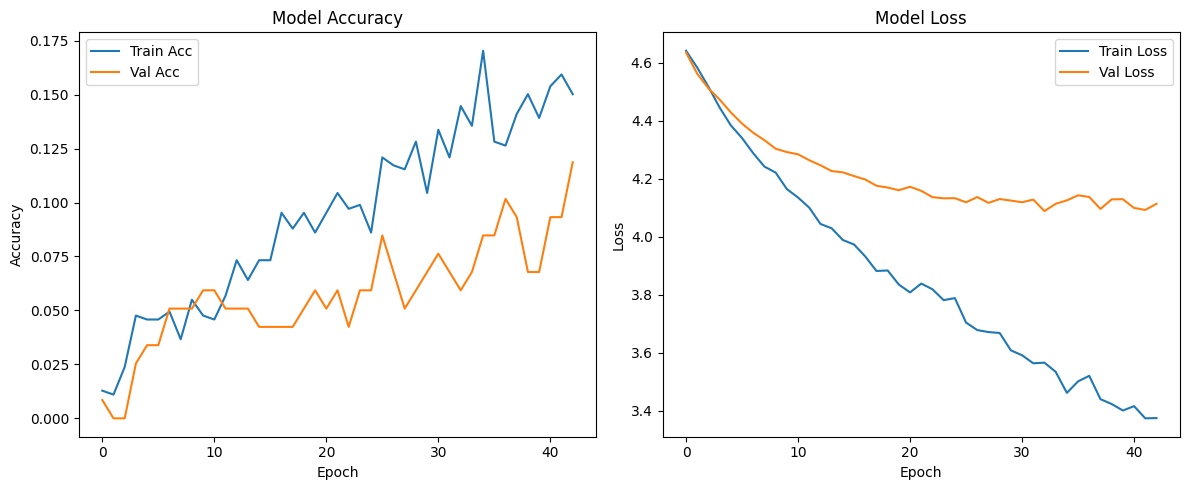

In [23]:
# Train the model with early stopping, save the model, and plot accuracy/loss curves
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Callbacks for early stopping and best model saving
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('birdsong_cnn_best.h5', save_best_only=True, monitor='val_loss', verbose=1)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint],
    verbose=2
    )

# Save the final model
model.save('birdsong_cnn_final.h5')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()